In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
import os

# Check if directories exist
IMG_PATH = "D:/Image Segmentation/preprocessed_images/train/images/"
MSK_PATH = "D:/Image Segmentation/Adult tooth segmentation dataset/data_split/train/masks/"

print(f"Image path exists: {os.path.exists(IMG_PATH)}")
print(f"Mask path exists: {os.path.exists(MSK_PATH)}")

if os.path.exists(IMG_PATH):
    files = os.listdir(IMG_PATH)
    print(f"Files in image path: {files[:5]}")  # Show first 5 files

Image path exists: True
Mask path exists: True
Files in image path: ['cate1-00001_preprocessed.jpg', 'cate1-00002_preprocessed.jpg', 'cate1-00003_preprocessed.jpg', 'cate1-00004_preprocessed.jpg', 'cate1-00005_preprocessed.jpg']


In [3]:
# Check if your preprocessed files have the expected naming
import os

IMG_PATH = "D:/Image Segmentation/preprocessed_images/train/images/"
if os.path.exists(IMG_PATH):
    files = os.listdir(IMG_PATH)
    print("Sample preprocessed filenames:")
    for f in files[:5]:
        print(f"  {f}")

Sample preprocessed filenames:
  cate1-00001_preprocessed.jpg
  cate1-00002_preprocessed.jpg
  cate1-00003_preprocessed.jpg
  cate1-00004_preprocessed.jpg
  cate1-00005_preprocessed.jpg


# **Plot Tooth Mask**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imread

def get_colored_mask(image, mask_image, color=[103, 193, 173]):
    """
    Create a colored mask overlay without using cv2
    
    Args:
        image: Original image (numpy array)
        mask_image: Mask image (numpy array)
        color: RGB color for the mask [R, G, B]
    
    Returns:
        Overlayed image (numpy array)
    """
    # Convert images to numpy arrays if they aren't already
    if isinstance(image, Image.Image):
        image = np.array(image)
    if isinstance(mask_image, Image.Image):
        mask_image = np.array(mask_image)
    
    # Ensure images are in the right format
    image = image.astype(np.float32)
    mask_image = mask_image.astype(np.float32)
    
    # Convert mask to grayscale if it's colored
    if len(mask_image.shape) == 3:
        # Convert RGB to grayscale using standard weights
        mask_gray = np.dot(mask_image[...,:3], [0.299, 0.587, 0.114])
    else:
        mask_gray = mask_image
    
    # Create colored mask
    mask_colored = np.zeros_like(image)
    
    # Find mask coordinates (where mask is not black/zero)
    mask_coords = np.where(mask_gray > 0)  # Non-zero pixels
    
    # Apply color to mask areas
    if len(mask_coords[0]) > 0:  # Check if there are any mask pixels
        mask_colored[mask_coords[0], mask_coords[1], 0] = color[0]  # Red
        mask_colored[mask_coords[0], mask_coords[1], 1] = color[1]  # Green  
        mask_colored[mask_coords[0], mask_coords[1], 2] = color[2]  # Blue
    
    # Blend images (equivalent to cv2.addWeighted)
    alpha = 0.6  # Weight for original image
    beta = 0.4   # Weight for mask
    
    # Normalize to 0-255 range if needed
    if image.max() <= 1.0:
        image = image * 255
    if mask_colored.max() <= 1.0:
        mask_colored = mask_colored * 255
    
    # Blend the images
    result = alpha * image + beta * mask_colored
    
    # Ensure values are in valid range
    result = np.clip(result, 0, 255).astype(np.uint8)
    
    return result

# Main visualization code
def visualize_masks(IMG_PATH, MSK_PATH, num_images=5):
    """
    Visualize images with their masks
    """
    filenames = next(os.walk(IMG_PATH))[2][:num_images]  # Get first 5 files

    for file in filenames:
        try:
            # Load image
            img_path = os.path.join(IMG_PATH, file)
            img = imread(img_path)

            # Convert mask filename (.jpg to .bmp)
            mask_file = file.replace('.jpg', '.bmp')
            mask_path = os.path.join(MSK_PATH, mask_file)

            # Check if mask exists
            if not os.path.exists(mask_path):
                print(f"Mask not found: {mask_path}")
                continue

            # Load mask
            msk = imread(mask_path)

            # Create overlay
            overlay = get_colored_mask(img, msk)

            # Display results
            plt.figure(figsize=(15, 5))

            plt.subplot(131)
            plt.imshow(img)
            plt.title("Image")
            plt.axis('off')  # Use axis('off') instead of box(False)

            plt.subplot(132)
            plt.imshow(msk, cmap='binary_r')
            plt.title("Mask")
            plt.axis('off')

            plt.subplot(133)
            plt.imshow(overlay)
            plt.title("Overlay")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

# **Data Generator**

In [5]:
from numpy import resize
from sklearn.model_selection import train_test_split

class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=8, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.

        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)

        # List image and mask files
        self.img_filenames = img_files
        self.mask_filenames = mask_files

        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        # Ensure the number of images matches the number of masks
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"

        self.indexes = np.arange(len(self.img_filenames))  # Indices for shuffling

        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).

        Args:
        - index: The index of the batch.

        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Initialize empty arrays for the batch
        images = []
        masks = []

        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = imread(IMG_PATH+self.img_filenames[idx],0)  # Read image
            img = resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask
            mask = imread(MSK_PATH+self.mask_filenames[idx],0)  # Read mask
            mask = resize(mask, self.size)  # Resize to target size
            # mask = cv2.dilate(mask, np.ones((15, 15), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = mask / 255.0  # Normalize to [0, 1]
            mask[mask > 0.5] = 1  # Binary mask

            # Add image and mask to the batch arrays
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.2,random_state=1)

train_data = DataGenerator(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=8,
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

In [6]:
print("Number of training images:", len(train_data.img_filenames))
print("Number of validation images:", len(val_data.img_filenames))

Number of training images: 1200
Number of validation images: 300


# **U-Net Model**

In [7]:
def unet(input_shape, num_classes):
    # Input layer for the model
    inputs = layers.Input(shape=input_shape)

    # Encoder Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

     # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model  # Return the model

# Instantiate the model
input_shape = (512, 512, 1)  # Define the input shape for grayscale images
model = unet(input_shape, 1)  # Create U-Net model for binary segmentation

# Print the model summary
model.summary()  # Display model architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

# **Evaluation Metrics**

In [8]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection) / (total)


def dice_coefficient(y_true, y_pred):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32

    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Calculate the Dice coefficient using the formula
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))


# Using the metrics in model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',dice_coefficient,jaccard_index])

# **Train the model**

In [ ]:
## ModelCheckpoint: Save the model with the best validation loss during training

checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
history = model.fit(
    train_data,                  # The training data generator or dataset
    validation_data=val_data,  # Validation data ratio
    epochs=30,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

Epoch 1/30


# **Plot training and validation results**

NameError: name 'history' is not defined

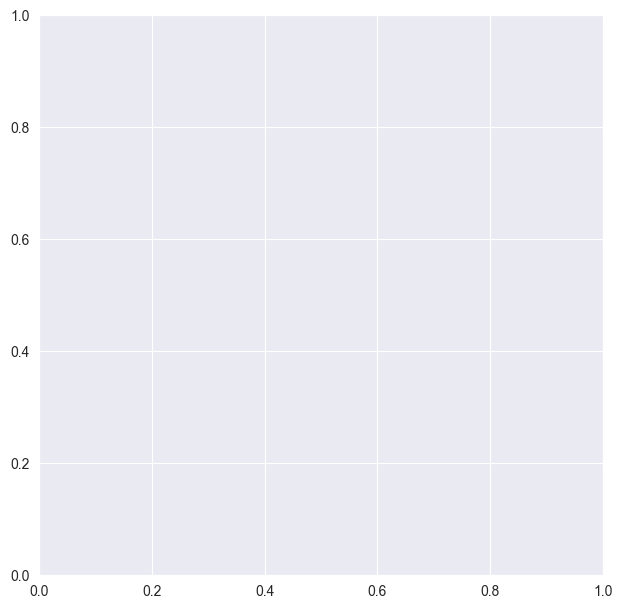

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training & validation accuracy values
plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation dice coefficient values
plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend(loc='lower right')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation jaccard index values
plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.legend(loc='lower right')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# **Visualize Segmentation Output**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_rgb(img):
    """
    Convert grayscale or single channel image to RGB without cv2
    """
    if len(img.shape) == 2:  # Grayscale (H, W)
        return np.stack([img, img, img], axis=-1)
    elif len(img.shape) == 3 and img.shape[-1] == 1:  # Single channel (H, W, 1)
        img_2d = np.squeeze(img, axis=-1)
        return np.stack([img_2d, img_2d, img_2d], axis=-1)
    elif len(img.shape) == 3 and img.shape[-1] == 3:  # Already RGB
        return img
    else:
        # Handle other cases by taking first 3 channels or repeating first channel
        if img.shape[-1] > 3:
            return img[:, :, :3]
        else:
            return np.stack([img[:, :, 0], img[:, :, 0], img[:, :, 0]], axis=-1)

def get_colored_mask(image, mask_image, color=[103, 193, 173]):
    """
    Create a colored mask overlay without using cv2
    """
    # Ensure inputs are numpy arrays
    image = np.array(image, dtype=np.float32)
    mask_image = np.array(mask_image, dtype=np.float32)
    
    # Normalize to 0-255 range if needed
    if image.max() <= 1.0:
        image = image * 255
    if mask_image.max() <= 1.0:
        mask_image = mask_image * 255
    
    # Convert mask to grayscale if it's RGB
    if len(mask_image.shape) == 3:
        # Convert RGB to grayscale using standard weights
        mask_gray = np.dot(mask_image[...,:3], [0.299, 0.587, 0.114])
    else:
        mask_gray = mask_image
    
    # Create colored mask
    mask_colored = np.zeros_like(image, dtype=np.float32)
    
    # Find mask coordinates (where mask is not black/zero)
    mask_coords = np.where(mask_gray > 128)  # Threshold for binary mask
    
    # Apply color to mask areas
    if len(mask_coords[0]) > 0:
        mask_colored[mask_coords[0], mask_coords[1], 0] = color[0]  # Red
        mask_colored[mask_coords[0], mask_coords[1], 1] = color[1]  # Green  
        mask_colored[mask_coords[0], mask_coords[1], 2] = color[2]  # Blue
    
    # Blend images (equivalent to cv2.addWeighted)
    alpha = 0.6  # Weight for original image
    beta = 0.4   # Weight for mask
    
    # Blend the images
    result = alpha * image + beta * mask_colored
    
    # Ensure values are in valid range
    result = np.clip(result, 0, 255).astype(np.uint8)
    
    return result

# Main prediction visualization code
def visualize_predictions(model, val_data, num_to_show=10):
    """
    Visualize model predictions without cv2
    """
    # Retrieve one batch (imgs, msks) from validation data
    imgs, msks = val_data.__getitem__(0)

    # Ensure we don't exceed the batch size
    num_to_show = min(num_to_show, len(imgs))

    for i in range(num_to_show):
        # Extract the i-th image and mask from the batch
        img = imgs[i]
        msk = msks[i]

        # Expand dims to feed into the model for prediction
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)

        # Convert model output to [0..255] uint8
        pred = (np.squeeze(pred) * 255).astype(np.uint8)

        # Convert the original image and mask to [0..255] uint8
        img_uint8 = (img * 255).astype(np.uint8)
        msk_uint8 = (msk * 255).astype(np.uint8)

        # Convert to 3-channel (RGB) if needed - WITHOUT cv2
        img_rgb = convert_to_rgb(img_uint8)
        msk_rgb = convert_to_rgb(msk_uint8)
        pred_rgb = convert_to_rgb(pred)

        # Create a figure for each sample
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(img_rgb)
        plt.title('Image')
        plt.yticks([])
        plt.xticks([])
        plt.axis('off')  # Better than plt.box(False)

        plt.subplot(132)
        # get_colored_mask overlays a colored mask on the image
        plt.imshow(get_colored_mask(img_rgb, msk_rgb))
        plt.title('Mask (Ground Truth)')
        plt.yticks([])
        plt.xticks([])
        plt.axis('off')

        plt.subplot(133)
        # Show the prediction overlay in a different color
        plt.imshow(get_colored_mask(img_rgb, pred_rgb, color=[255, 30, 0]))
        plt.title('Mask (Prediction)')
        plt.yticks([])
        plt.xticks([])
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Alternative: Batch visualization
def visualize_predictions_batch(model, val_data, batch_idx=0, num_cols=5):
    """
    Visualize multiple predictions in a grid layout
    """
    # Get batch data
    imgs, msks = val_data.__getitem__(batch_idx)
    num_samples = min(len(imgs), 10)
    
    # Calculate grid dimensions
    num_rows = (num_samples + num_cols - 1) // num_cols
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_rows * 3, num_cols, figsize=(num_cols * 4, num_rows * 9))
    
    for i in range(num_samples):
        # Get predictions
        img = imgs[i]
        msk = msks[i]
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred = np.squeeze(pred)
        
        # Convert to uint8 and RGB
        img_rgb = convert_to_rgb((img * 255).astype(np.uint8))
        msk_rgb = convert_to_rgb((msk * 255).astype(np.uint8))
        pred_rgb = convert_to_rgb((pred * 255).astype(np.uint8))
        
        # Calculate subplot positions
        col = i % num_cols
        row_base = (i // num_cols) * 3
        
        # Original image
        if num_rows > 1:
            axes[row_base, col].imshow(img_rgb)
            axes[row_base, col].set_title(f'Image {i+1}')
            axes[row_base, col].axis('off')
            
            # Ground truth
            axes[row_base + 1, col].imshow(get_colored_mask(img_rgb, msk_rgb))
            axes[row_base + 1, col].set_title('Ground Truth')
            axes[row_base + 1, col].axis('off')
            
            # Prediction
            axes[row_base + 2, col].imshow(get_colored_mask(img_rgb, pred_rgb, color=[255, 30, 0]))
            axes[row_base + 2, col].set_title('Prediction')
            axes[row_base + 2, col].axis('off')
        else:
            # Single row case
            axes[row_base, col].imshow(img_rgb)
            axes[row_base, col].set_title(f'Image {i+1}')
            axes[row_base, col].axis('off')
    
    # Hide empty subplots
    total_subplots = num_rows * num_cols * 3
    for i in range(num_samples * 3, total_subplots):
        row = i // num_cols
        col = i % num_cols
        if num_rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_data, num_to_show=10)